In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import spatial
from scipy.stats import norm
import pdb
%matplotlib inline

C:\Users\johnn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# data_path = r'C:\Users\johnny.wong\PycharmProjects\NBA pricing\Personal\Data\nba_odds_raw.csv'
data_path = r'C:\Users\johnn\Desktop\github\nba_stats\Data\nba_odds_raw.csv'
raw_odds = pd.read_csv(data_path)

clean_odds = raw_odds.copy()
clean_odds['date_string'] = clean_odds.apply(lambda row:str(row.DD)+'-'+str(row.MM)+'-'+str(row.YY), axis=1)
clean_odds['Date'] = clean_odds.date_string.apply(lambda date_str: dt.datetime.strptime(date_str, '%d-%b-%Y'))

clean_odds['Avg_A_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Away odds 1'], row['Away odds 2'], 
                                                                   row['Away odds 3']]), axis=1)
clean_odds['Avg_H_odds'] = clean_odds.apply(lambda row:np.nanmean([row['Home odds 1'], row['Home odds 2'], 
                                                                   row['Home odds 3']]), axis=1)

clean_odds['IP'] = 1/clean_odds.Avg_H_odds + 1/clean_odds.Avg_A_odds
clean_odds['Standardised_H_odds'] = clean_odds.Avg_H_odds * clean_odds.IP
clean_odds['Standardised_A_odds'] = clean_odds.Avg_A_odds * clean_odds.IP
clean_odds['Standardised_IP'] = 1/clean_odds['Standardised_H_odds'] + 1/clean_odds['Standardised_A_odds']
clean_odds['favourite_odds'] = clean_odds.apply(lambda row: min(row.Standardised_H_odds, row.Standardised_A_odds), axis=1)

# Remove bad data
clean_odds = clean_odds[raw_odds['Total score'] > 50]
clean_odds = clean_odds[~clean_odds.Avg_A_odds.isnull()]
assert len(clean_odds[(clean_odds.Standardised_IP - 1).abs() > 0.01]) == 0
clean_odds.head()

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


,YY,DD,MM,Seasons,Home team,Away team,Home ID,Away ID,End of regulation score,Home final score,Away final score,Winning team,Total score,Home odds 1,Away odds 1,Home odds 2,Away odds 2,Home odds 3,Away odds 3,date_string,Date,Avg_A_odds,Avg_H_odds,IP,Standardised_H_odds,Standardised_A_odds,Standardised_IP,favourite_odds
0,2019,11,Feb,2018/2019,Golden State Warriors,Miami Heat,GSW,MIA,NaN,120.0,118.0,H,238.0,1.08,10.40,1.08,10.16,1.07,9.50,11-Feb-2019,2019-02-11,10.020000,1.076667,1.028593,1.107452,10.306502,1.0,1.107452
1,2019,11,Feb,2018/2019,Atlanta Hawks,Orlando Magic,ATL,ORL,NaN,108.0,124.0,A,232.0,2.06,1.62,2.04,1.87,2.20,1.71,11-Feb-2019,2019-02-11,1.733333,2.100000,1.053114,2.211538,1.825397,1.0,1.825397
2,2019,10,Feb,2018/2019,Sacramento Kings,Phoenix Suns,SAC,PHX,NaN,117.0,104.0,H,221.0,1.19,3.90,1.24,4.65,1.26,4.00,10-Feb-2019,2019-02-10,4.183333,1.230000,1.052052,1.294024,4.401084,1.0,1.294024
3,2019,10,Feb,2018/2019,Philadelphia 76ers,Los Angeles Lakers,PHI,LAL,NaN,143.0,120.0,H,263.0,1.33,3.00,1.34,3.56,1.34,3.35,10-Feb-2019,2019-02-10,3.303333,1.336667,1.050854,1.404642,3.471322,1.0,1.404642
4,2019,10,Feb,2018/2019,Dallas Mavericks,Portland Trail Blazers,DAL,POR,NaN,102.0,101.0,H,203.0,2.61,1.57,2.62,1.56,1.74,2.15,10-Feb-2019,2019-02-10,1.760000,2.323333,0.998598,2.320076,1.757532,1.0,1.757532


Plot the home winning margin against the home implied probabilities

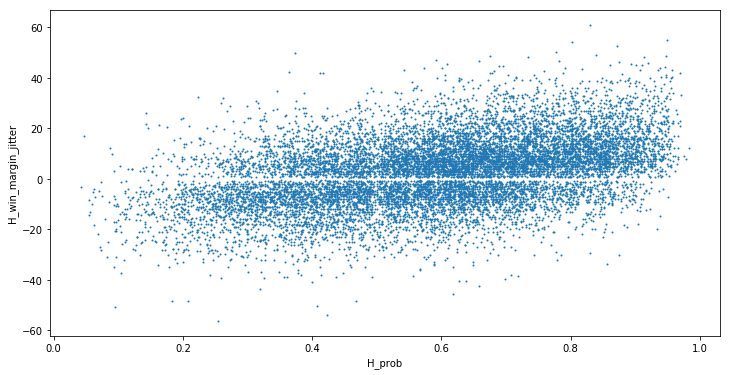

In [4]:
clean_odds['H_prob'] = 1/clean_odds['Standardised_H_odds']
clean_odds['A_prob'] = 1/clean_odds['Standardised_A_odds']
clean_odds['H_win_margin'] = clean_odds['Home final score'] - clean_odds['Away final score']
clean_odds['H_win_margin_jitter'] = clean_odds['H_win_margin'] + np.random.normal(scale=0.2, size=len(clean_odds))
clean_odds.plot(x='H_prob', y='H_win_margin_jitter', kind='scatter', figsize=(12, 6), s=1)

Clear relationship between the probability of a winning, and winning margin. Looks fairly linear, let's run a regression.

In [5]:
margin_prob_regr = LinearRegression()
margin_prob_regr.fit(clean_odds.H_prob.reshape(-1, 1), clean_odds.H_win_margin)
print('Intercept {:.2f}\nGradient {:.2f}'.format(margin_prob_regr.intercept_, margin_prob_regr.coef_[0]))
print('At 50% win, predicts {:.2f}'.format(margin_prob_regr.predict([[0.5]])[0]))

Intercept -15.79
Gradient 31.41
At 50% win, predicts -0.09


C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


Good that at 50%, the model spits out a predicted margin very close to 0. This makes sense. As an aside, it seems like home teams have more 90%+ games than 10%- games. Will be something to look into but makes sense due to home court advantage.

## Plotting regression and analysis of residuals

Text(0,0.5,'Home team winning margin')

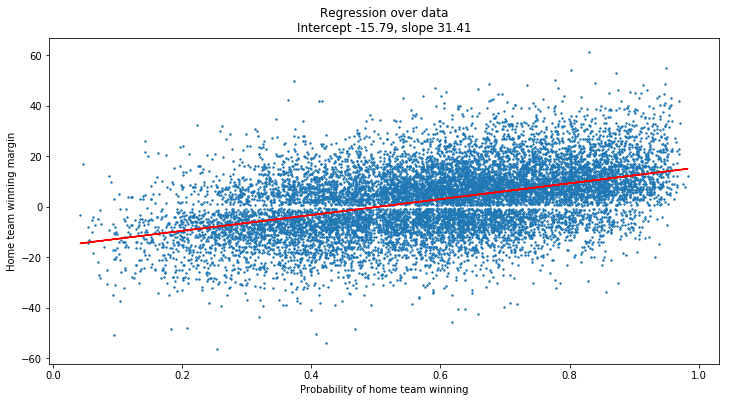

In [6]:
clean_odds['Pred_H_win_margin'] = margin_prob_regr.predict(clean_odds['H_prob'].values.reshape(-1,1))

plt.figure(figsize=(12,6))

plt.scatter(x=clean_odds.H_prob, y=clean_odds.H_win_margin_jitter, s=2)
plt.plot(clean_odds.H_prob,clean_odds.Pred_H_win_margin, 'r-')

plt.title('Regression over data\nIntercept {:.2f}, slope {:.2f}'.format(
    margin_prob_regr.intercept_, margin_prob_regr.coef_[0]))
plt.xlabel('Probability of home team winning')
plt.ylabel('Home team winning margin')

Text(0,0.5,'Actual home team margin minus expected')

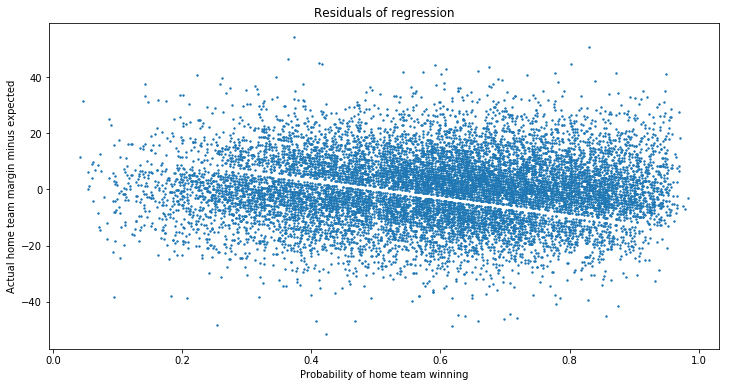

In [7]:
clean_odds['residual'] = clean_odds['H_win_margin'] - clean_odds['Pred_H_win_margin']
plt.figure(figsize=(12,6))

plt.scatter(x=clean_odds.H_prob, y=clean_odds.residual, s=2)

plt.title('Residuals of regression')
plt.xlabel('Probability of home team winning')
plt.ylabel('Actual home team margin minus expected')

After plotting squared residuals, seems a bit heteroskedastic. Looks like there might be more variance around the 40-70% region than the wings.

Text(0.5,1,'Residuals squared')

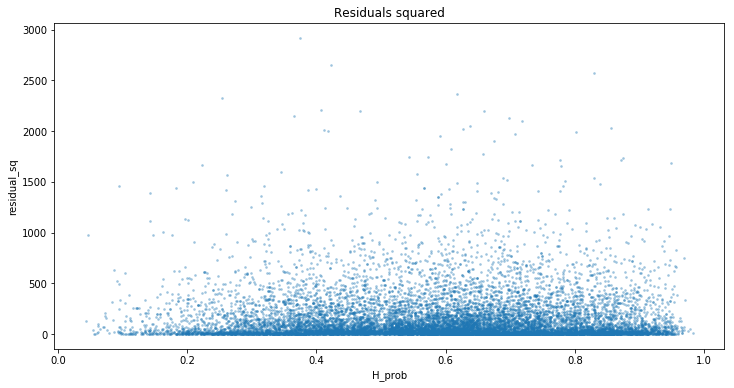

In [8]:
clean_odds['residual_sq'] = clean_odds['residual']  ** 2

clean_odds.plot(x='H_prob', y='residual_sq', kind='scatter', s=3, figsize=(12, 6), alpha=0.3)
plt.title('Residuals squared')

(0, 400)

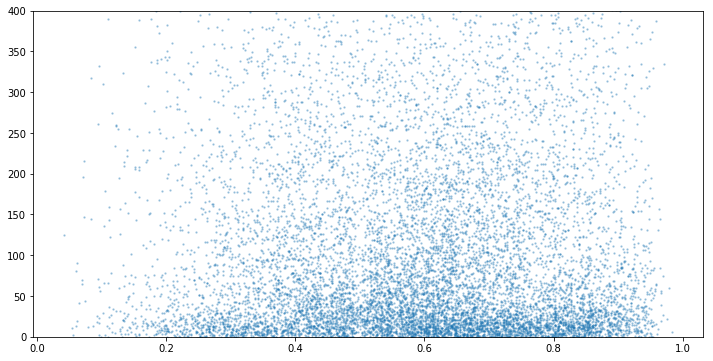

In [9]:
y_upper = 400
plt.figure(figsize=(12,6))
plt.scatter(x=clean_odds['H_prob'], 
            y=clean_odds['residual_sq'] + np.random.normal(scale=10, size=len(clean_odds)),
           s=2, alpha=0.3)
plt.ylim((0, y_upper))

### Testing for heterskedasticity
Hypothesis is that variance decreases at the wings and increases near the 50%, so split the data up and run a regression on the squared residuals to see if there is a significant trend.

In [10]:
h_prob_under_60 = clean_odds[clean_odds.H_prob < 0.6]
h_prob_over_60 = clean_odds[clean_odds.H_prob > 0.6]

under_60_regr = LinearRegression()
under_60_regr.fit(X=h_prob_under_60.H_prob.values.reshape(-1,1), y=h_prob_under_60.residual_sq)

over_60_regr = LinearRegression()
over_60_regr.fit(X=h_prob_over_60.H_prob.values.reshape(-1,1), y=h_prob_over_60.residual_sq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0.5,0.98,'Residual squared across different subsets')

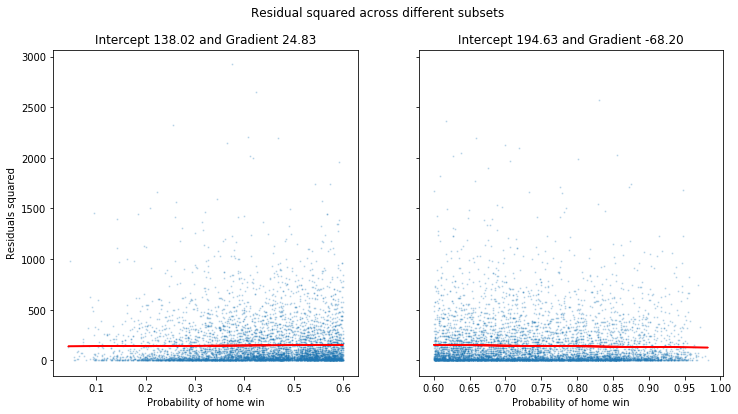

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6))

ax[0].scatter(h_prob_under_60.H_prob, h_prob_under_60.residual_sq, s=1, alpha=0.2)
ax[0].plot(h_prob_under_60.H_prob, 
           under_60_regr.predict(h_prob_under_60.H_prob.values.reshape(-1,1)),
          color='r')
ax[0].set_xlabel('Probability of home win')
ax[0].set_ylabel('Residuals squared')
ax[0].set_title('Intercept {:.2f} and Gradient {:.2f}'.format(under_60_regr.intercept_, under_60_regr.coef_[0]))

ax[1].scatter(h_prob_over_60.H_prob, h_prob_over_60.residual_sq, s=1, alpha=0.2)
ax[1].plot(h_prob_over_60.H_prob, 
           over_60_regr.predict(h_prob_over_60.H_prob.values.reshape(-1,1)),
          color='r')
ax[1].set_xlabel('Probability of home win')
ax[1].set_title('Intercept {:.2f} and Gradient {:.2f}'.format(over_60_regr.intercept_, over_60_regr.coef_[0]))

fig.suptitle('Residual squared across different subsets')

For under 60%, a gradient of 24.83 suggests that the difference in variance between a 20% probability and 60% probability is 0.4x24.83 = 9.932, which is significant enough that it shouldn't be ignored.
The regression on the left predicts a variance of 153 for 60% win, while the regression on the right predicts also predicts 153. This is good as it suggests the arbitrarily chosen 60% is probably a good split. Out of curiosity, I wanted to see how a LOESS regression would look on the full dataset before continuing further.

It's hard to see on the left chart the effect of lowess regression, it is clearer to see on the right chart.

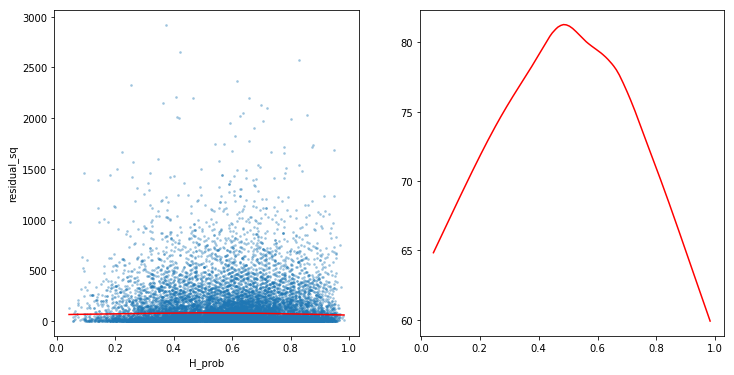

In [12]:
lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, delta=0.01)

lowess_x = [x[0] for x in lowess_variance]
lowess_y = [y[1] for y in lowess_variance]

fig, ax = plt.subplots(1, 2)
clean_odds.plot(x='H_prob', y='residual_sq', kind='scatter', s=3, figsize=(12, 6), alpha=0.3, ax=ax[0])
ax[0].plot(lowess_x, lowess_y, color='red')
ax[1].plot(lowess_x, lowess_y, color='red')

This turned out to be quite informative! It seems fairly linear from 0 up to around 45% and from about 70% to 100%. I'm going to run the lowess regression over multiple parameters just to see if the shape differs by much.

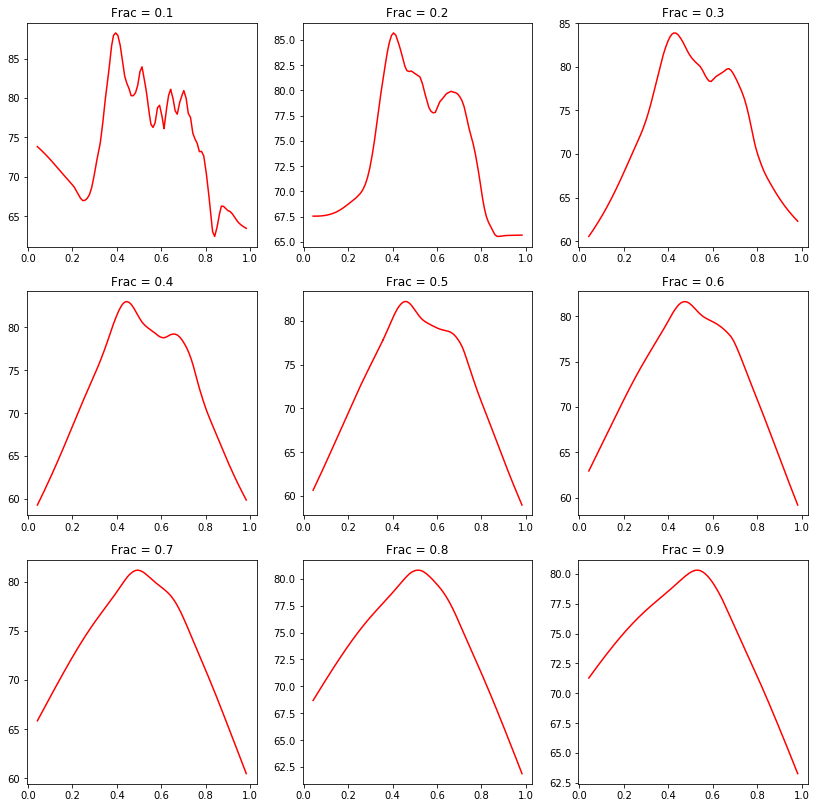

In [13]:
frac_params = np.linspace(0.1, 0.9, 9)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i, frac in enumerate(frac_params):
    plt.subplot(3, 3, i+1)
    lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, frac=frac, delta=0.01)
    lowess_x = [x[0] for x in lowess_variance]
    lowess_y = [y[1] for y in lowess_variance]
    plt.plot(lowess_x, lowess_y, color='red')
    plt.title('Frac = {:.1f}'.format(frac))

While there are some weird shapes, frac 0.5 seems smooth enough to make sense whilst capturing important info on the variance, so I will elect to use that as my variance predictor. I tried to split it up until multiple linear regressions below, but it doesn't seem to be very smooth. For now I will give up the parameterisation in favour of smoothness.

In [14]:
h_prob_under_45 = clean_odds[clean_odds.H_prob < 0.45]
h_prob_45_to_70 = clean_odds[(clean_odds.H_prob >= 0.45) & (clean_odds.H_prob <= 0.7)]
h_prob_over_70 = clean_odds[clean_odds.H_prob > 0.7]

under_45_regr = LinearRegression()
under_45_regr.fit(X=h_prob_under_45.H_prob.values.reshape(-1,1), y=h_prob_under_45.residual_sq)

between_45_70_regr = LinearRegression()
between_45_70_regr.fit(X=h_prob_45_to_70.H_prob.values.reshape(-1,1), y=h_prob_45_to_70.residual_sq)

over_70_regr = LinearRegression()
over_70_regr.fit(X=h_prob_over_70.H_prob.values.reshape(-1,1), y=h_prob_over_70.residual_sq)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

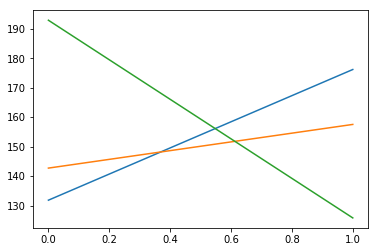

In [15]:
x_0_to_1 = np.linspace(0, 1, 101)
plt.plot(x_0_to_1, under_45_regr.predict(x_0_to_1.reshape(-1,1)))
plt.plot(x_0_to_1, between_45_70_regr.predict(x_0_to_1.reshape(-1,1)))
plt.plot(x_0_to_1, over_70_regr.predict(x_0_to_1.reshape(-1,1)))

In [16]:
def margin_variance(H_prob):
    ''' Returns the variance of the margin based on the probability of the home team winning '''
    if H_prob <=0.45:
        return under_45_regr.predict([[H_prob]])
    elif H_prob <=0.7:
        return between_45_70_regr.predict([[H_prob]])
    else:
        return over_70_regr.predict([[H_prob]])

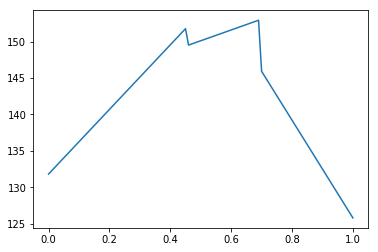

In [17]:
plt.plot(x_0_to_1, [margin_variance(H_prob) for H_prob in x_0_to_1])

In [18]:
lowess_variance = sm.nonparametric.lowess(clean_odds.residual_sq, clean_odds.H_prob, delta=0.01, frac=0.5)
def margin_variance_lowess(H_prob, lowess_model):
    lowess_prob = [[x[0]] for x in lowess_model]
    lowess_var = [y[1] for y in lowess_model]
    
    tree = spatial.KDTree(lowess_prob)
    d, i = tree.query([H_prob])
    
    return lowess_var[i]

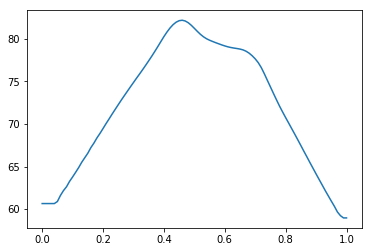

In [19]:
plt.plot(x_0_to_1, [margin_variance_lowess(H_prob, lowess_variance) for H_prob in x_0_to_1])

## Distribution
I'm going to take a sample of games with roughly equal variance, and plot the histogram to see what the distribution looks like.

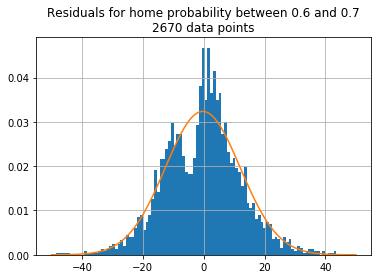

In [20]:
prob_lower_bound = 0.6
prob_upper_bound = 0.7

sample_of_residuals = clean_odds[(clean_odds.H_prob >= prob_lower_bound) & 
                                 (clean_odds.H_prob <= prob_upper_bound)]
sample_of_residuals.hist(column='residual', bins=100, density=True)
plt.title('Residuals for home probability between ' + str(prob_lower_bound) + 
         ' and ' + str(prob_upper_bound) + '\n' + str(len(sample_of_residuals)) + ' data points')
sample_mean = sample_of_residuals.residual.mean()
sample_std_dev = sample_of_residuals.residual.std()
x = np.linspace(-50, 50, 100)
plt.plot(x, norm.pdf(x, sample_mean, sample_std_dev))

Plotting a normal distribution overlay reveals an eerily accurate fit! One interesting feature of this histogram is a distinctive dip in the data. This can be explained by the fact that the win margin cannot be 0. So if the model predicts a win margin of say, 8.7, then the residual can't be 8.7 exactly. It would likely be either 8 or 9.
So while the normal distribution fits quite well in the tails, there is less datapoints where the residuals imply a winning margin of 0, and more datapoints directly above and below that.
This feature of the histograms is present in every range of home win probabilities as shown below.

C:\Users\johnn\Anaconda3\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


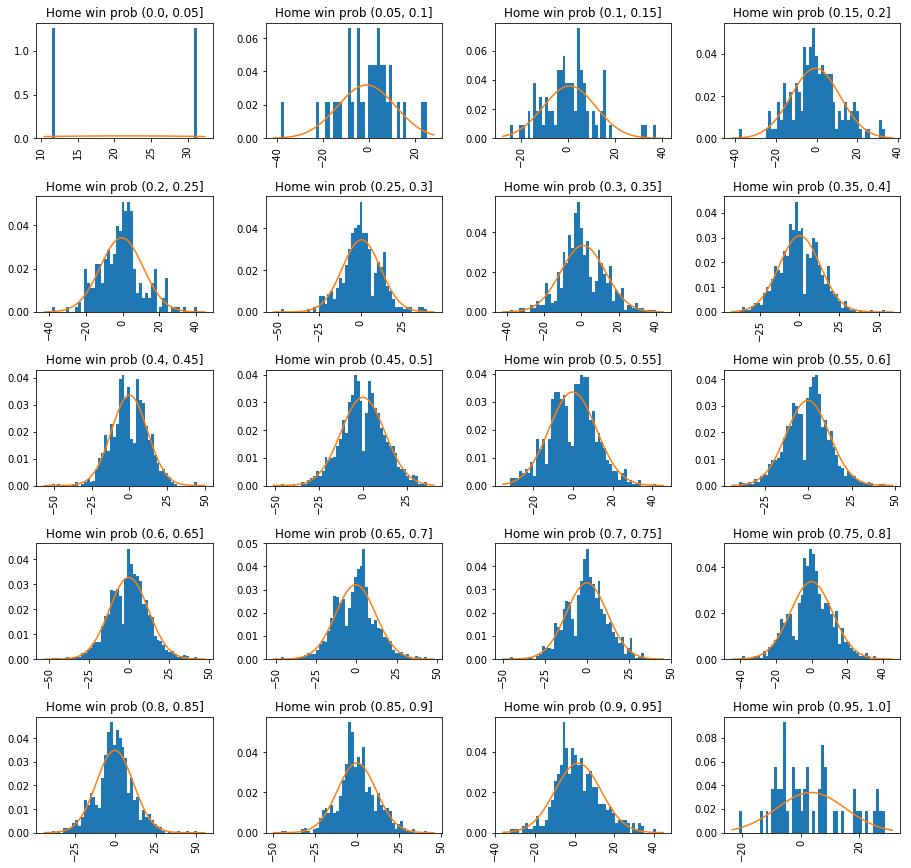

In [21]:
clean_odds['H_prob_bin'] = pd.cut(clean_odds.H_prob, np.linspace(0, 1, 21))
ax = clean_odds.hist(column='residual', by='H_prob_bin', figsize=(15, 15), bins=50, density=True)
gaussian_params = clean_odds.groupby('H_prob_bin').agg({'residual':{'Avg_res':'mean',
                                                                   'Std_dev_res':'std'}})
gaussian_params.columns = gaussian_params.columns.droplevel()

for i in range(ax.shape[0] * ax.shape[1]):
    axes = ax.flat[i]
    
    # Get parameter estimates
    avg = gaussian_params.iloc[i].Avg_res
    std_dev = gaussian_params.iloc[i].Std_dev_res
    
    # Plot gaussian pdf
    x_min, x_max = axes.get_xlim()
    x = np.linspace(x_min, x_max, 100)
    axes.plot(x, norm.pdf(x, avg, std_dev))
    
    axes.set_title('Home win prob ' + axes.title.get_text())

## Pricing options
Now that we have an underlying distribution for the margin, let's price some options. The value of a call option with strike $K$ is
$$\mathbb{E}[(X-K)^+]$$
Where X is the distribution of the underlying (in this case the margin) which is assumed normal with mean $\mu$ and variance $\sigma^2$ with pdf $f$ and cdf $F$.
Unpacking this, 

\begin{align}
\mathbb{E}[(X-K)^+] & = \int^\infty_K (x-K)f(x)dx\\
& = \int^\infty_K xf(x)dx - K\int^\infty_K f(x)dx \\
& = \mathbb{E}[X\, |\, X \geq K] \times Pr(X \geq K) - K \times Pr(X \geq K) \\
& = \mathbb{E}[X\, |\, X \geq K] \times (1-F(K)) - K \times (1-F(K)) \\
\end{align}

The first term on the right is similar to the expected value of a [truncated normal distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution)
\begin{align}
\mathbb{E}[X\, |\, X \geq K] & = \mu + \frac{f(K)}{1 - F(K)}
\end{align}

Substituting the above equality in, we get the value of the call:
\begin{align}
\mathbb{E}[(X-K)^+] & = \mu \, [1 - F(K))]+ \sigma \, f(K) - K[1-F(K)]
\end{align}

We can work out the value of the put with PC parity

In [22]:
def call_value(strike, mu, sigma):
    k = (strike - mu)/sigma
    C = mu*(1-norm.cdf(k)) + sigma*norm.pdf(k)-strike*(1-norm.cdf(k))
    return C

def put_value(strike, mu, sigma):
    return call_value(strike, mu, sigma) - mu + strike

Text(0,0.5,'Value')

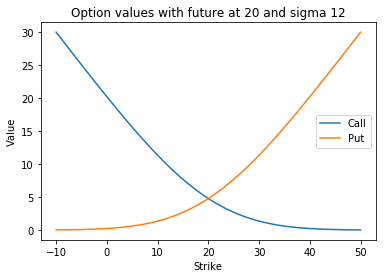

In [23]:
strikes = list(range(-10, 51))
mu = 20
sigma = 12
plt.plot(strikes, [call_value(K, mu, sigma) for K in strikes], label='Call')
plt.plot(strikes, [put_value(K, mu, sigma) for K in strikes], label='Put')
plt.legend()
plt.title('Option values with future at {} and sigma {}'.format(mu, sigma))
plt.xlabel('Strike')
plt.ylabel('Value')

# Putting it all together
Starting with the odds, we can calculate the expected home win margin and the variance. With this, we can calculate the values of calls and puts assuming that the home win margin is normally distributed. Let's wrap this up in one neat function.

In [24]:
def call(strike, home_odds, away_odds=None, future=None, sigma=None):
    '''
    Returns the theo price for a call option and a given strike and home odds of winning. 
    Underlying is the home team winning margin
    If away odds aren't specified, home odds are assumed fair.
    '''
    # Find the probability of the home team winning
    if away_odds is None:
        H_prob = 1/home_odds
    else:
        # Take the midpoint as the fair probability of the home team winning
        imp_prob = 1/home_odds + 1/away_odds
        H_prob = 1/(home_odds * imp_prob)
    
    # Find future theo
    if future is None:
        margin_intercept = margin_prob_regr.intercept_
        margin_slope = margin_prob_regr.coef_[0]
        future_theo = margin_intercept + margin_slope * H_prob
    else:
        future_theo = future
        
    # Find standard deviation
    if sigma is None:
        variance = margin_variance_lowess(H_prob, lowess_variance)
    else:
        variance = sigma ** 2
    sigma_theo = variance ** 0.5
    
    # Return call price
    return call_value(strike, future_theo, sigma_theo)

def put(strike, home_odds, away_odds=None, future=None, sigma=None):
    '''
    Returns the theo price for a put option and a given strike and home odds of winning. 
    Underlying is the home team winning margin
    If away odds aren't specified, home odds are assumed fair.
    '''
    # Find probability of home team winning
    if away_odds is None:
        H_prob = 1/home_odds
    else:
        # Take the midpoint as the fair probability of the home team winning
        imp_prob = 1/home_odds + 1/away_odds
        H_prob = 1/(home_odds * imp_prob)
    
    # Find future theo
    if future is None:
        margin_intercept = margin_prob_regr.intercept_
        margin_slope = margin_prob_regr.coef_[0]
        future_theo = margin_intercept + margin_slope * H_prob
    else:
        future_theo = future

    return call(strike, home_odds, away_odds, future_theo, sigma) - future_theo + strike

In [25]:
def df_option_theos(home_odds, away_odds=None, future=None, sigma=None, 
                    first_strike=-20, last_strike=20, increment=1):
    '''
    Returns a dataframe containing options theos
    '''
    strikes = []
    call_theo = []
    put_theo = []

    for strike in range(first_strike, last_strike+increment, increment):
        strikes.append(strike)
        call_theo.append(call(strike, home_odds, away_odds, future, sigma))
        put_theo.append(put(strike, home_odds, away_odds, future, sigma))
    
    df_theos = pd.DataFrame(data={
        'Call':call_theo,
        'Strike':strikes,
        'Put':put_theo,
    },
                           columns=['Call', 'Strike', 'Put'])
    
    df_theos['Future'] = df_theos.Call - df_theos.Put + df_theos.Strike
    return df_theos

In [26]:
df_option_theos(2.27, 1.66, first_strike=-10, last_strike=15)

,Call,Strike,Put,Future
0,8.504155,-10,1.031442,-2.527287
1,7.724071,-9,1.251358,-2.527287
2,6.978155,-8,1.505442,-2.527287
3,6.269004,-7,1.796291,-2.527287
4,5.598929,-6,2.126216,-2.527287
5,4.969880,-5,2.497167,-2.527287
6,4.383381,-4,2.910668,-2.527287
7,3.840473,-3,3.367759,-2.527287
8,3.341679,-2,3.868966,-2.527287
9,2.886984,-1,4.414271,-2.527287
